In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
from particles import resampling as rs
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixtureAlgorithms as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/SMC-WFR/utils.py'>

In [2]:
w = 1/2
sigma = 1
weights = np.array([w, 1-w])

In [3]:
m = np.arange(1, 11)
d = 1

In [4]:
N = 500
X0 = np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N)
Nrep = 50
Niter = 200
Niter_ula = Niter*10
gamma = 0.1

In [5]:
LSI = 1 + (np.exp(m**2)+1)/2
LSI

array([2.85914091e+00, 2.87990750e+01, 4.05304196e+03, 4.44305676e+06,
       3.60024497e+10, 2.15561577e+15, 9.53673286e+20, 3.11757454e+27,
       7.53048657e+34, 1.34405857e+43])

In [6]:
times_ula = np.zeros((Niter_ula, m.size, Nrep))
mmd_ula = np.zeros((Niter_ula, m.size, Nrep))

times_wfr = np.zeros((Niter, m.size, Nrep))
mmd_wfr = np.zeros((Niter, m.size, Nrep))

In [7]:
for h in range(m.size):
    ms = np.array([np.zeros(d), m[h]*np.ones(d)])
    Sigmas = np.array([sigma*np.eye(d), sigma*np.eye(d)])
    component = np.random.choice(2, p = weights, size = N)
    true_sample = np.zeros((N, d))
    for n in range(N):
        true_sample[n, :] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)
    for j in range(Nrep):
        # ULA
        Xula = np.zeros((Niter_ula, d, N))
        Xula[0, :, :] = X0.T
        for i in range(1, Niter_ula):
            start = time.time()
            gradient = algo.gradient_mixture(Xula[i-1, :, :], ms, Sigmas, weights)
            Xula[i, :, :] = Xula[i-1, :, :] + gamma*gradient + np.sqrt(2*gamma)*np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N).T
            end = time.time()        
            times_ula[i, h, j] = end-start
            mmd_ula[i, h, j] = u.mmd_rbf(true_sample, Xula[i, :, :].T)
        # WFR
        Xwfr = np.zeros((Niter, d, N))
        Wwfr = np.zeros((Niter, N))
        Xwfr[0, :] = X0.T
        Wwfr[0, :] = np.ones(N)/N
        for i in range(1, Niter):
            start = time.time()
            if (i > 1):
                # resample
                ancestors = rs.resampling('stratified', Wwfr[i-1, :])
                Xwfr[i-1, :, :] = Xwfr[i-1, :, ancestors].T
            # MCMC move
            gradient_step = Xwfr[i-1, :, :] + gamma*algo.gradient_mixture(Xwfr[i-1, :, :], ms, Sigmas, weights)
            Xwfr[i, :, :] = gradient_step + np.sqrt(2*gamma)*np.random.multivariate_normal(np.zeros(d), np.eye(d), size = N).T
            # reweight
            gaussian_convolution = multivariate_normal.pdf(np.kron(Xwfr[i, :, :].T, np.ones((N, 1))) - np.tile(gradient_step, N).T, np.zeros(d), 2*gamma*np.eye(d)).reshape(N, N)
            weight_denominator = np.mean(gaussian_convolution, axis = 1)
            logW = (1-np.exp(-gamma))*(algo.logpi_mixture(Xwfr[i, :, :], ms, Sigmas, weights)-np.log(weight_denominator))
            Wwfr[i, :] = rs.exp_and_normalise(logW)
            end = time.time()        
            times_wfr[i, h, j] = end-start
            mmd_wfr[i, h, j] = u.mmd_rbf(true_sample, Xwfr[i, :, :].T, w = Wwfr[i, :])

In [8]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

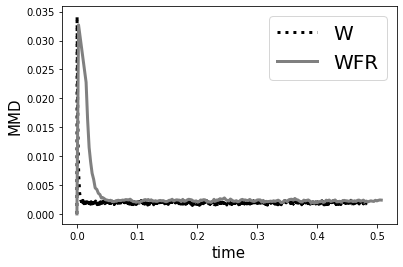

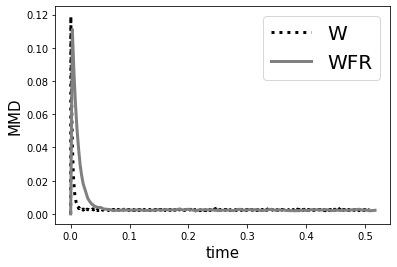

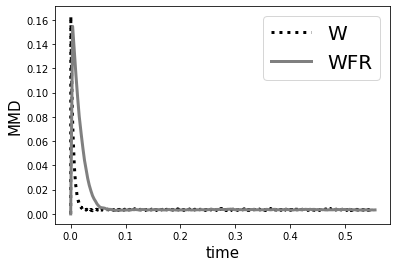

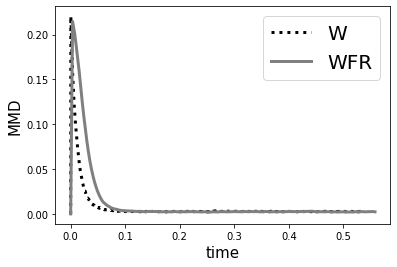

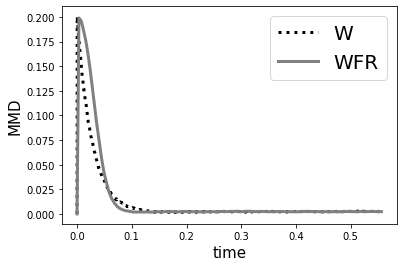

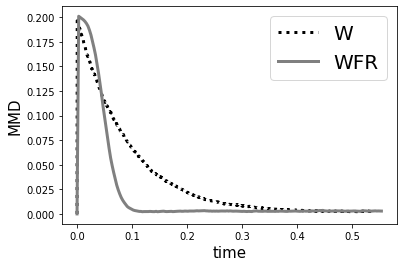

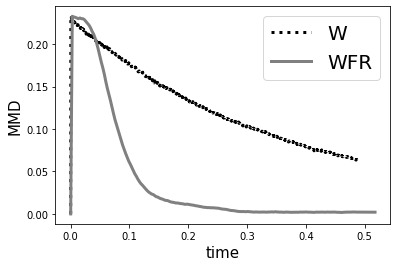

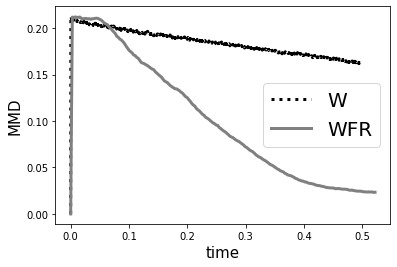

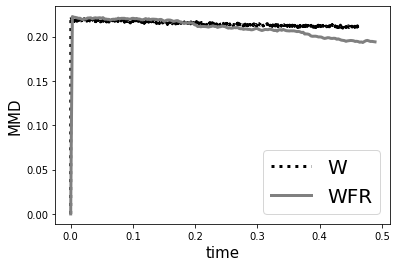

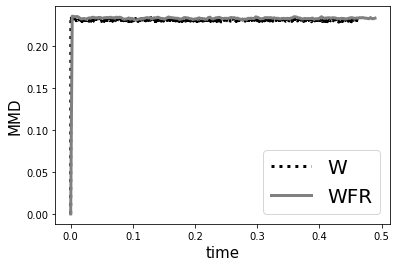

In [17]:
for i in range(m.size):
    plt.plot(np.mean(np.cumsum(times_ula[:, i, :], axis = 0), axis = 1), np.mean(mmd_ula[:, i, :], axis = 1), label = 'W', lw = 3, c='black', linestyle = 'dotted');
    plt.plot(np.mean(np.cumsum(times_wfr[:, i, :], axis = 0), axis = 1), np.mean(mmd_wfr[:, i, :], axis = 1), label = 'WFR', lw = 3, c='gray');
    plt.legend(fontsize = 20)
    plt.xlabel('time', fontsize = 15)
    plt.ylabel('MMD', fontsize = 15)
#     plt.savefig(f"gaussian_mix_cost{i+1}.pdf", bbox_inches='tight')
    plt.show()